## Multi-armed bandit algorithms: Implementation and performance analysis

In [1]:
# Package imports
import numpy as np
import matplotlib.pyplot as plt

# For plotting figures inline
%matplotlib inline
plt.rcParams['figure.figsize'] = (15., 5.)
plt.rcParams['axes.titlesize'] = 15.
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.labelsize'] = 14.
plt.rcParams['legend.fontsize'] = 14.
plt.rcParams['legend.loc'] = 'center right'

### Useful utility functions

In [2]:
def argmax(values):
    max_val = values[0]
    best_actions = [0]
    for i in range(1, len(values)):
        if values[i] > max_val:
            max_val = values[i]
            best_actions = [i]
        elif values[i] == max_val:
            best_actions.append(i)
    return np.random.choice(best_actions)

In [3]:
def softmax(values):
    max_val = np.amax(values)
    exps = np.exp(values - max_val)
    return exps / np.sum(exps)

### The 10-armed Testbed

- True action values $\mu = q_*(a)$ are drawn/redrawn from a stanard normal distribution each time we run the testbed
- Reward is sampled from a normal distribution, with $\mu = q_*(a)$, $\sigma^2 = 1$

In [4]:
class Testbed:
    
    def __init__(self, arms, mean=0., var=1., stationary=True):
        self.arms = arms
        self.mean = mean
        self.var = var
        self.stationary = stationary
        
        self.reset()

    def get_reward(self, action):
        if not self.stationary and self.count == 500: self.reset()
        self.count += 1
        return np.random.normal(self.q_actuals[action], 1.)

    def reset(self):
        self.count = 0
        self.q_actuals = np.random.normal(self.mean, self.var, self.arms)
        self.q_optimal = np.amax(self.q_actuals)
        self.optimal_action = np.argmax(self.q_actuals)

### Agent

In [5]:
class Agent:
    
    def __init__(self, arms, strategy, **params):
        self.arms = arms
        self.strategy = strategy
        self.params = params
        self.estimates = np.full(arms, params['init_val']) if 'init_val' in self.params else np.zeros(arms)
        self.action_counts = np.zeros(arms)
        self.prob = None
        self.rewards_sum = 0.

    def pull(self):
        if self.strategy == 'epsilon_greedy':
            epsilon = self.params['epsilon']
            if np.random.random_sample() < epsilon:
                action = np.random.randint(self.arms) # Explore
            else:
                action = argmax(self.estimates) # Exploit
        
        elif self.strategy == 'ucb':
            c = self.params['c']
            if 0 in self.action_counts:
                unused_arms = np.where(self.action_counts == 0)[0]
                action = np.random.choice(unused_arms)
            else:
                total_steps = np.sum(self.action_counts)
                ucb_terms = self.estimates + c * np.sqrt(np.log(total_steps)/self.action_counts)
                action = argmax(ucb_terms)
                
        elif self.strategy == 'gradient':
            self.prob = softmax(self.estimates)
            action = np.random.choice(self.arms, p=self.prob)
        
        self.action_counts[action] += 1
        
        return action

    def update_estimate(self, reward, action):
        if self.strategy in ['epsilon_greedy', 'ucb']:
            step_size = self.params['step_size'] if 'step_size' in self.params else 1./self.action_counts[action]
            self.estimates[action] += step_size * (reward - self.estimates[action])
        elif self.strategy == 'gradient':
            step_size = self.params['step_size']
            delta = reward
            baseline = self.params['baseline']
            if baseline:
                self.rewards_sum += reward
                total_steps = np.sum(self.action_counts)
                delta -= self.rewards_sum / total_steps

            self.estimates[action] += step_size * delta * (1. - self.prob[action])
            self.estimates[:action] -= step_size * delta * self.prob[:action]
            self.estimates[action+1:] -= step_size * delta * self.prob[action+1:]

    def reset(self):
        self.estimates[:] = self.params['init_val'] if 'init_val' in self.params else 0.
        self.rewards_sum = 0.
        self.action_counts[:] = 0

### Environment

In [6]:
class Environment:

    def __init__(self, pulls, iterations, testbed):
        self.pulls = pulls
        self.iterations = iterations
        self.testbed = testbed

    def run(self, agent):
        scores_avg = []
        optimal_counts = np.zeros(self.pulls)
        
        # Logger
        msg = f'{agent.strategy} agent:'
        for k, v in agent.params.items():
            msg += f' {k}={v},'
        msg += f' environment={"stationary." if self.testbed.stationary else "non-stationary."}'
        print(msg + '\n' + '-' * len(msg))
    
        for i in range(self.iterations):
            # Set a random seed for each iteration/experiment
            np.random.seed(i)
            
            # Reset the testbed and agent
            self.testbed.reset()
            agent.reset()
            
            # Choose actions through time-steps / Pull arms
            rewards_sum = 0.
            scores = []
            for p in range(self.pulls):
                # Pull an arm > get reward > update value-estimate
                action = agent.pull()
                reward = self.testbed.get_reward(action)
                agent.update_estimate(reward, action)

                # Store avg. reward at each time-step/pull
                rewards_sum += reward
                scores.append(rewards_sum/(p+1))
                
                # Store total no. of optimal actions chosen (over iterations/experiments) at each time-step/pull
                if action == self.testbed.optimal_action:
                    optimal_counts[p] += 1
                    
            scores_avg.append(scores)
            
            if i%100 == 99 or i == self.iterations-1:
                print(f'No. of iterations completed: {i+1}')
                
        print()
        
        scores_avg = np.mean(scores_avg, axis=0)
        optimal_counts /= self.iterations
        
        return scores_avg, optimal_counts
    
    def reset(self, testbed):
        self.testbed = testbed

In [7]:
arms = 10  # no. of arms/actions
pulls = 1000  # time-steps in each run
iterations = 2000  # no. of iterations/experiments

# Initialize standard 10-armed testbed & environment
testbed  = Testbed(arms)
env = Environment(pulls, iterations, testbed)

### Agents with $\epsilon$-greedy action selection

In [8]:
eps = [0., 0.01, 0.1, 0.4]

scores_avg_eps = []
optimal_counts_eps = []
for e in eps:
    agent = Agent(arms, strategy='epsilon_greedy', epsilon=e)
    scores_avg, optimal_counts = env.run(agent)
    scores_avg_eps.append(scores_avg)
    optimal_counts_eps.append(optimal_counts)

epsilon_greedy agent: epsilon=0.0, environment=stationary.
----------------------------------------------------------
No. of iterations completed: 100
No. of iterations completed: 200
No. of iterations completed: 300
No. of iterations completed: 400
No. of iterations completed: 500
No. of iterations completed: 600
No. of iterations completed: 700
No. of iterations completed: 800
No. of iterations completed: 900
No. of iterations completed: 1000
No. of iterations completed: 1100
No. of iterations completed: 1200
No. of iterations completed: 1300
No. of iterations completed: 1400
No. of iterations completed: 1500
No. of iterations completed: 1600
No. of iterations completed: 1700
No. of iterations completed: 1800
No. of iterations completed: 1900
No. of iterations completed: 2000

epsilon_greedy agent: epsilon=0.01, environment=stationary.
-----------------------------------------------------------
No. of iterations completed: 100
No. of iterations completed: 200
No. of iterations comple

### Compare $\epsilon$-greedy agents with different $\epsilon$ values

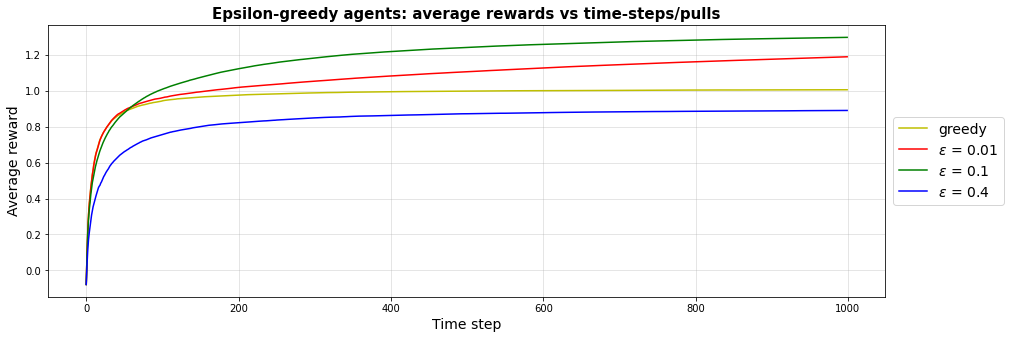

In [9]:
# Plot rewards averaged over runs (iters) vs time-steps/pulls
for i, v in enumerate(['y', 'r', 'g', 'b']):
    plt.plot(scores_avg_eps[i], color=v)
plt.title('Epsilon-greedy agents: average rewards vs time-steps/pulls')
plt.xlabel('Time step')
plt.ylabel('Average reward')
plt.legend(
    [
        'greedy',
        fr'$\epsilon$ = {eps[1]}',
        fr'$\epsilon$ = {eps[2]}',
        fr'$\epsilon$ = {eps[3]}'
    ],
    bbox_to_anchor=(1.15, 0.5)
)
plt.grid(alpha=0.4)
plt.show()

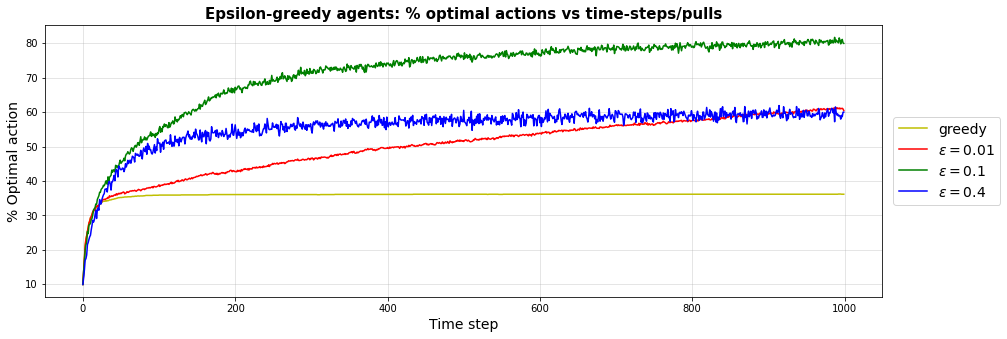

In [10]:
# Plot optimal action counts averaged over runs (iters) vs time-steps/pulls
for i, v in enumerate(['y', 'r', 'g', 'b']):
    plt.plot(optimal_counts_eps[i]*100, color=v)    
plt.title('Epsilon-greedy agents: % optimal actions vs time-steps/pulls')
plt.xlabel('Time step')
plt.ylabel('% Optimal action')
plt.legend(
    [
        'greedy',
        fr'$\epsilon = {eps[1]}$',
        fr'$\epsilon = {eps[2]}$',
        fr'$\epsilon = {eps[3]}$'
    ],
    bbox_to_anchor=(1.15, 0.5)
)
plt.grid(alpha=0.4)
plt.show()

### Effect of Optimistic Initial Values

In [11]:
agent = Agent(arms, strategy='epsilon_greedy', epsilon=0., step_size=0.1, init_val=5.)
_, optimal_counts_oiv = env.run(agent)

epsilon_greedy agent: epsilon=0.0, step_size=0.1, init_val=5.0, environment=stationary.
---------------------------------------------------------------------------------------
No. of iterations completed: 100
No. of iterations completed: 200
No. of iterations completed: 300
No. of iterations completed: 400
No. of iterations completed: 500
No. of iterations completed: 600
No. of iterations completed: 700
No. of iterations completed: 800
No. of iterations completed: 900
No. of iterations completed: 1000
No. of iterations completed: 1100
No. of iterations completed: 1200
No. of iterations completed: 1300
No. of iterations completed: 1400
No. of iterations completed: 1500
No. of iterations completed: 1600
No. of iterations completed: 1700
No. of iterations completed: 1800
No. of iterations completed: 1900
No. of iterations completed: 2000



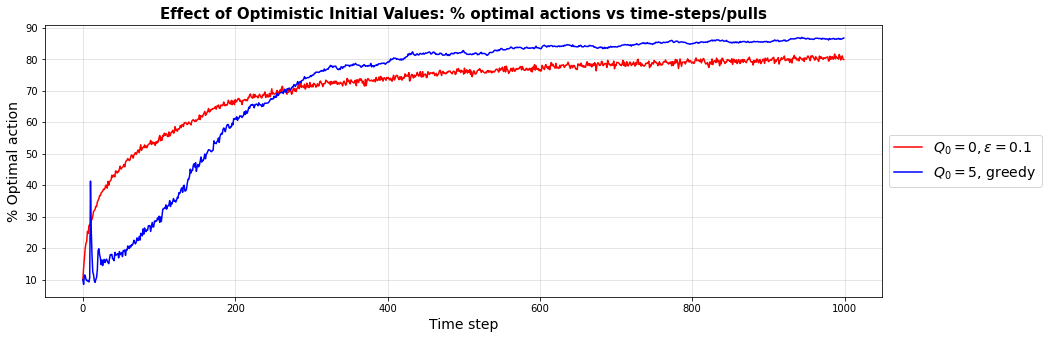

In [12]:
# Plot optimal action counts averaged over runs (iters) vs time-steps/pulls
plt.plot(optimal_counts_eps[2]*100, color='r')
plt.plot(optimal_counts_oiv*100, color='b')
plt.title('Effect of Optimistic Initial Values: % optimal actions vs time-steps/pulls')
plt.xlabel('Time step')
plt.ylabel('% Optimal action')
plt.legend([fr'$Q_0 = 0, \epsilon = {eps[2]}$', r'$Q_0 = 5$, greedy'], bbox_to_anchor=(1.2, 0.5))
plt.grid(alpha=0.4)
plt.show()

### Non-stationary problem

In [13]:
testbed_ns  = Testbed(arms, stationary=False)
env.reset(testbed_ns)

agent_1 = Agent(arms, strategy='epsilon_greedy', epsilon=0.1)
agent_2 = Agent(arms, strategy='epsilon_greedy', epsilon=0.1, step_size=0.1)

scores_avg_ns = []
for agent in [agent_1, agent_2]:
    scores_avg, _ = env.run(agent)
    scores_avg_ns.append(scores_avg)


epsilon_greedy agent: epsilon=0.1, environment=non-stationary.
--------------------------------------------------------------
No. of iterations completed: 100
No. of iterations completed: 200
No. of iterations completed: 300
No. of iterations completed: 400
No. of iterations completed: 500
No. of iterations completed: 600
No. of iterations completed: 700
No. of iterations completed: 800
No. of iterations completed: 900
No. of iterations completed: 1000
No. of iterations completed: 1100
No. of iterations completed: 1200
No. of iterations completed: 1300
No. of iterations completed: 1400
No. of iterations completed: 1500
No. of iterations completed: 1600
No. of iterations completed: 1700
No. of iterations completed: 1800
No. of iterations completed: 1900
No. of iterations completed: 2000

epsilon_greedy agent: epsilon=0.1, step_size=0.1, environment=non-stationary.
-----------------------------------------------------------------------------
No. of iterations completed: 100
No. of iterat

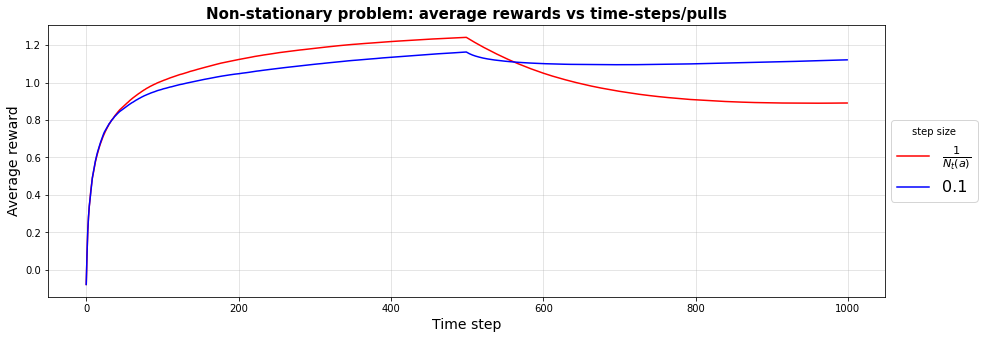

In [14]:
# Plot rewards averaged over runs (iters) vs time-steps/pulls
plt.plot(scores_avg_ns[0], color='r')
plt.plot(scores_avg_ns[1], color='b')
plt.title('Non-stationary problem: average rewards vs time-steps/pulls')
plt.xlabel('Time step')
plt.ylabel('Average reward')
plt.legend([r'$\frac{1}{N_t(a)}$', '0.1'], title='step size', bbox_to_anchor=(1.12, 0.5), fontsize=16.)
plt.grid(alpha=0.4)
plt.show()

### Agents with UCB action selection

In [15]:
env.reset(testbed)  # Reset env for stationary case

scores_avg_ucb = []
optimal_counts_ucb = []
for v in [1, 2]:
    agent = Agent(arms, strategy='ucb', c=v)
    scores_avg, optimal_counts = env.run(agent)
    scores_avg_ucb.append(scores_avg)
    optimal_counts_ucb.append(optimal_counts)

ucb agent: c=1, environment=stationary.
---------------------------------------
No. of iterations completed: 100
No. of iterations completed: 200
No. of iterations completed: 300
No. of iterations completed: 400
No. of iterations completed: 500
No. of iterations completed: 600
No. of iterations completed: 700
No. of iterations completed: 800
No. of iterations completed: 900
No. of iterations completed: 1000
No. of iterations completed: 1100
No. of iterations completed: 1200
No. of iterations completed: 1300
No. of iterations completed: 1400
No. of iterations completed: 1500
No. of iterations completed: 1600
No. of iterations completed: 1700
No. of iterations completed: 1800
No. of iterations completed: 1900
No. of iterations completed: 2000

ucb agent: c=2, environment=stationary.
---------------------------------------
No. of iterations completed: 100
No. of iterations completed: 200
No. of iterations completed: 300
No. of iterations completed: 400
No. of iterations completed: 500
No.

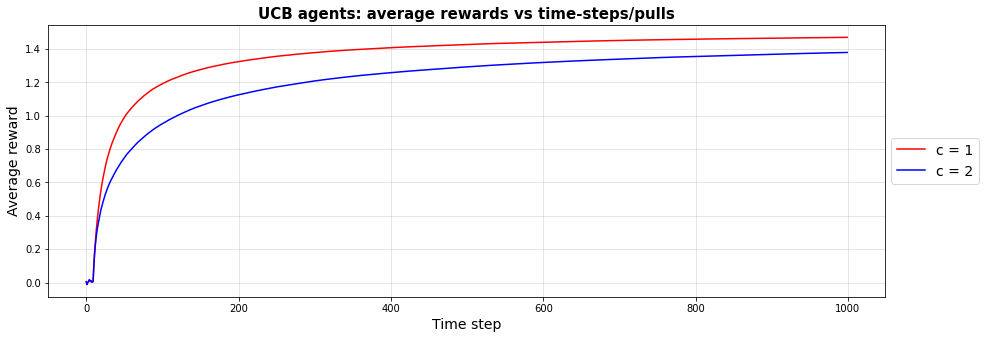

In [16]:
# Plot rewards averaged over runs (iters) vs time-steps/pulls
plt.plot(scores_avg_ucb[0], color='r')
plt.plot(scores_avg_ucb[1], color='b')
plt.title('UCB agents: average rewards vs time-steps/pulls')
plt.xlabel('Time step')
plt.ylabel('Average reward')
plt.legend(['c = 1', 'c = 2'], bbox_to_anchor=(1.12, 0.5))
plt.grid(alpha=0.4)
plt.show()

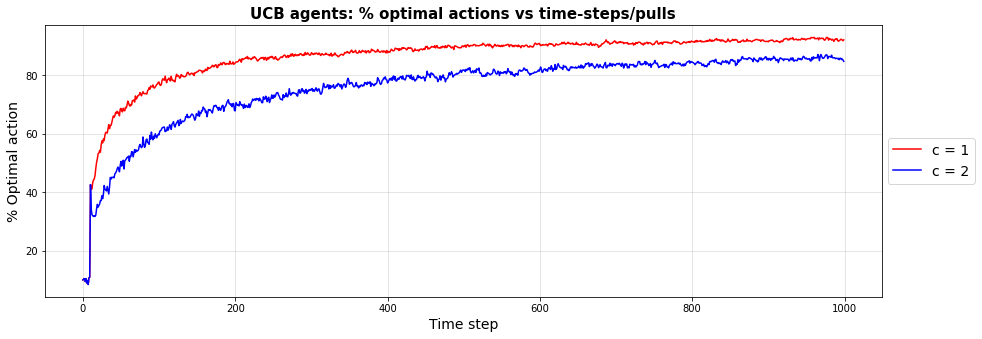

In [17]:
# Plot optimal action counts averaged over runs (iters) vs time-steps/pulls
plt.plot(optimal_counts_ucb[0]*100, color='r')
plt.plot(optimal_counts_ucb[1]*100, color='b')
plt.title('UCB agents: % optimal actions vs time-steps/pulls')
plt.xlabel('Time step')
plt.ylabel('% Optimal action')
plt.legend(['c = 1', 'c = 2'], bbox_to_anchor=(1.12, 0.5))
plt.grid(alpha=0.4)
plt.show()

### Compare UCB with $\epsilon$-greedy action selection

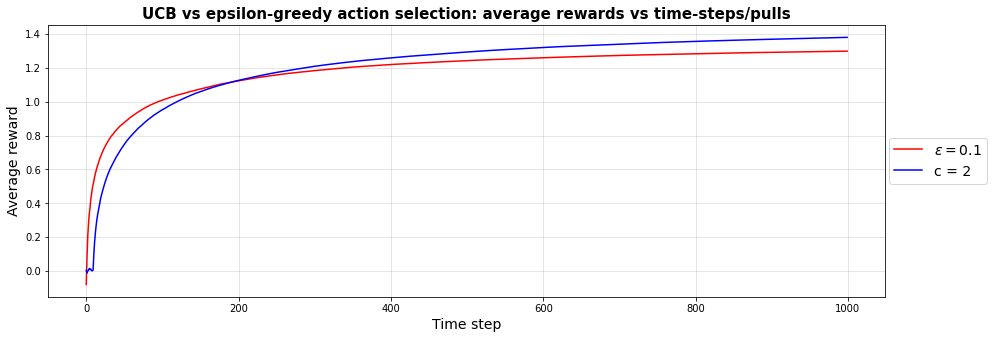

In [18]:
# Plot rewards averaged over runs (iters) vs time-steps/pulls
plt.plot(scores_avg_eps[2], color='r')
plt.plot(scores_avg_ucb[1], color='b')
plt.title('UCB vs epsilon-greedy action selection: average rewards vs time-steps/pulls')
plt.xlabel('Time step')
plt.ylabel('Average reward')
plt.legend([fr'$\epsilon = {eps[2]}$', 'c = 2'], bbox_to_anchor=(1.13, 0.5))
plt.grid(alpha=0.4)
plt.show()

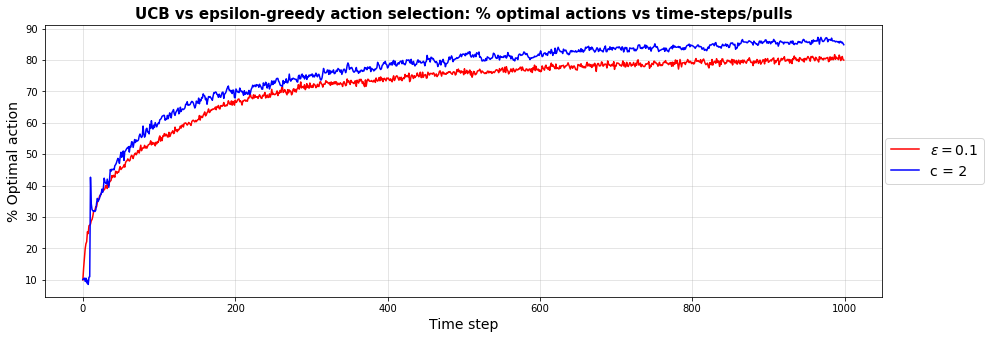

In [19]:
# Plot optimal action counts averaged over runs (iters) vs no. of time-steps/pulls
plt.plot(optimal_counts_eps[2]*100, color='r')
plt.plot(optimal_counts_ucb[1]*100, color='b')
plt.title('UCB vs epsilon-greedy action selection: % optimal actions vs time-steps/pulls')
plt.xlabel('Time step')
plt.ylabel('% Optimal action')
plt.legend([fr'$\epsilon = {eps[2]}$', 'c = 2'], bbox_to_anchor=(1.13, 0.5))
plt.grid(alpha=0.4)
plt.show()

### Gradient Bandit Algorithms

In [20]:
testbed_gb  = Testbed(arms, mean=4.)
env.reset(testbed_gb)

optimal_counts_gb = []
pairs = ([0.1, True],[0.4, True],[0.1, False],[0.4, False])
for s, b in pairs:
    agent = Agent(arms, strategy='gradient', step_size=s , baseline=b)
    _, optimal_counts = env.run(agent)
    optimal_counts_gb.append(optimal_counts)

gradient agent: step_size=0.1, baseline=True, environment=stationary.
---------------------------------------------------------------------
No. of iterations completed: 100
No. of iterations completed: 200
No. of iterations completed: 300
No. of iterations completed: 400
No. of iterations completed: 500
No. of iterations completed: 600
No. of iterations completed: 700
No. of iterations completed: 800
No. of iterations completed: 900
No. of iterations completed: 1000
No. of iterations completed: 1100
No. of iterations completed: 1200
No. of iterations completed: 1300
No. of iterations completed: 1400
No. of iterations completed: 1500
No. of iterations completed: 1600
No. of iterations completed: 1700
No. of iterations completed: 1800
No. of iterations completed: 1900
No. of iterations completed: 2000

gradient agent: step_size=0.4, baseline=True, environment=stationary.
---------------------------------------------------------------------
No. of iterations completed: 100
No. of iteratio

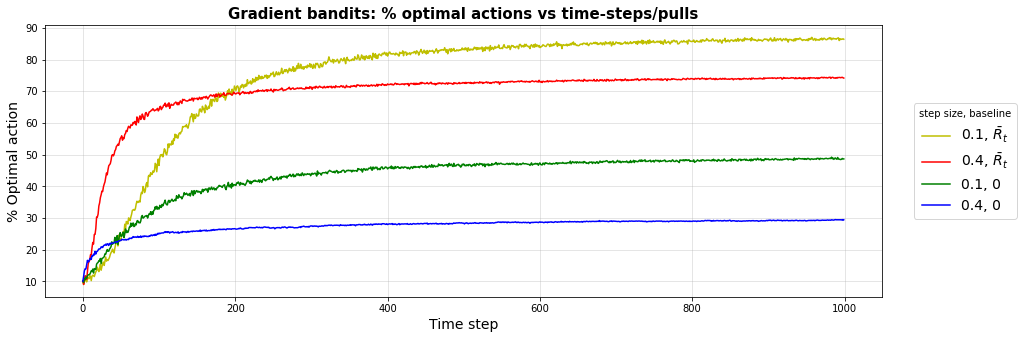

In [21]:
# Plot optimal action counts averaged over runs (iters) vs time-steps/pulls
for i, v in enumerate(['y', 'r', 'g', 'b']):
    plt.plot(optimal_counts_gb[i]*100, color=v)
plt.title('Gradient bandits: % optimal actions vs time-steps/pulls')
plt.xlabel('Time step')
plt.ylabel('% Optimal action')
plt.legend(['{}, {}'.format(s, r'$\bar{R}_t$' if b else 0) for s, b in pairs],
           title=r'step size, baseline',
           bbox_to_anchor=(1.17, 0.5)
          )
plt.grid(alpha=0.4)
plt.show()